In [18]:
import nltk
import pandas as pd
import cloudscraper
from bs4 import BeautifulSoup
from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import pickle
from nltk.stem import SnowballStemmer
from tqdm import tqdm
from nltk.corpus import stopwords
from concurrent.futures import as_completed, ThreadPoolExecutor
from wordcloud import WordCloud
import torch.nn.functional as F
import matplotlib.pyplot as plt
import spacy
from transformers import BertForSequenceClassification, Trainer, TrainingArguments


In [2]:
nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))
english_stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='french')
tqdm.pandas()
french_stopwords.update(["ajout", "pani", "tous", "recherche", "achet", "tnd","wishlist", "span","euro"])
english_stopwords.update(["add", "pani", "all", "search", "buy", "tnd","wishlist"])
nlp = spacy.load("fr_core_news_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('cleaned_results.csv')
scraper = cloudscraper.create_scraper()

In [4]:
data = {
    'url': df['URL'].tolist(),
    'label': df['Classification'].tolist()
}

In [19]:
def fetch_content(url):
    try:
        r = scraper.get(url, timeout=10)
        soup = BeautifulSoup(r.content, 'lxml')
        metas = soup.find_all("meta")
        description = (" ".join([meta["content"] if "description" in str(meta) else "" for meta in metas])).strip()
        for tag in soup(['script', 'style', 'noscript', 'iframe', 'link', 'comment', 'footer', 'header','meta','span']):
            tag.decompose()
        combined_text = soup.get_text(separator=' ', strip=True)
        filtered_words = [word for word in combined_text.split() if word.lower() not in french_stopwords and word.lower() not in english_stopwords]
        stemmed_words = {stemmer.stem(word) for word in filtered_words}  # Use a set to remove duplicates
        doc = nlp(" ".join(stemmed_words).strip()+" "+description)
        return (" ".join([token.lemma_ for token in doc if not token.is_stop])).strip()
    except Exception as e:
        return

def fetch_all_meta_descriptions(urls):
    results = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_content, url): url for url in urls}
        for future in tqdm(as_completed(futures), total=len(futures)):
            results.append(future.result())
    return results

In [6]:
df = pd.DataFrame(data)
df['content'] = fetch_all_meta_descriptions(df['url'].tolist())
df = df[df['content'].str.strip().astype(bool)]

100%|██████████| 240/240 [00:41<00:00,  5.80it/s]


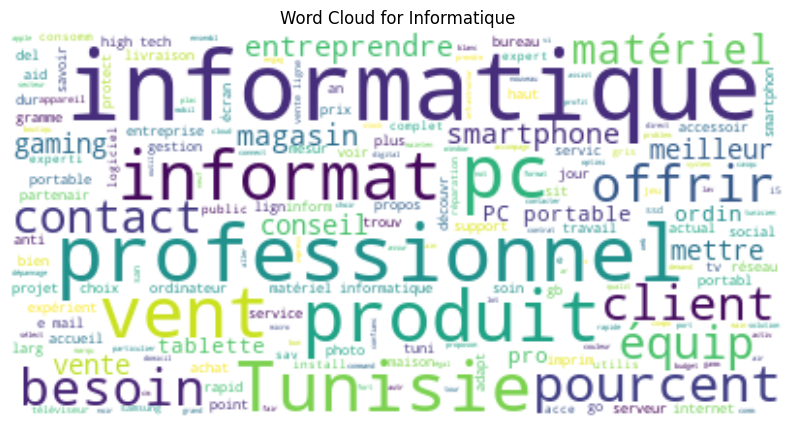

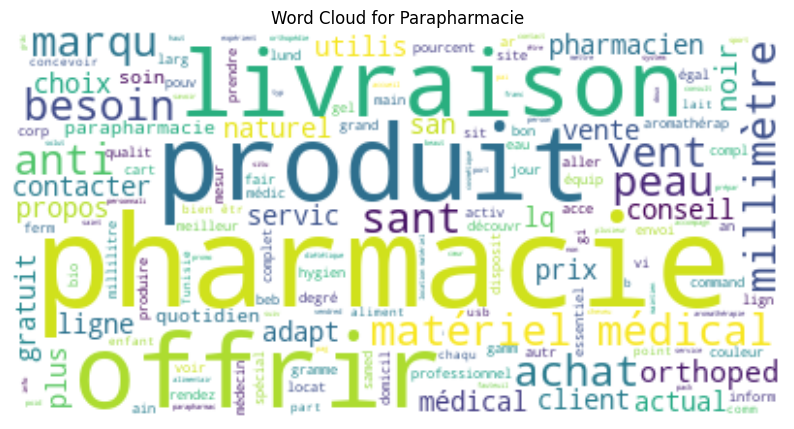

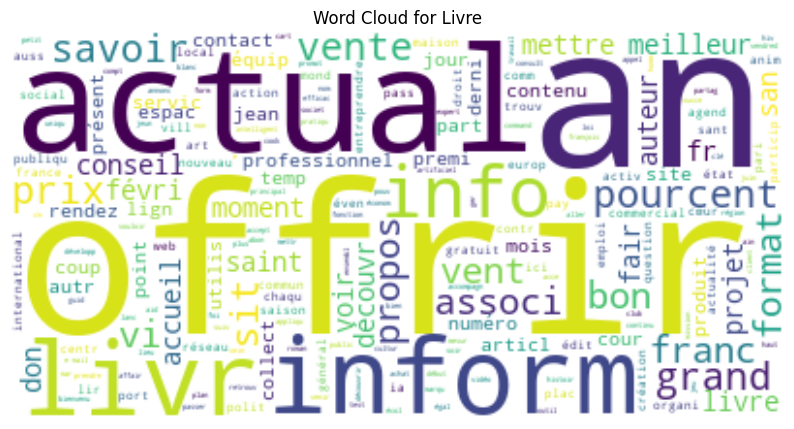

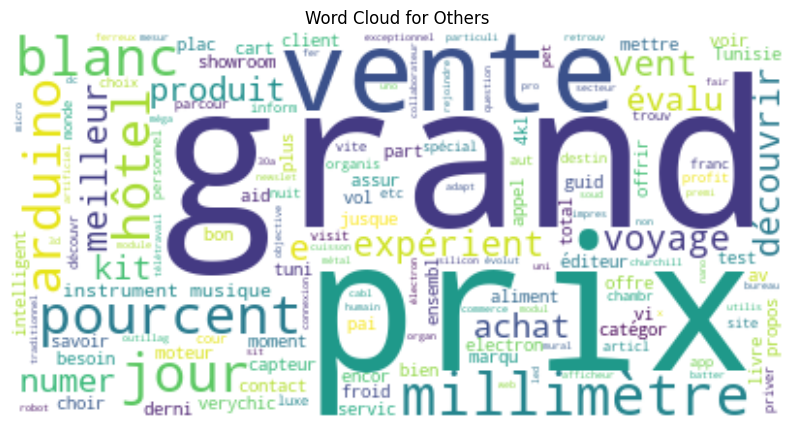

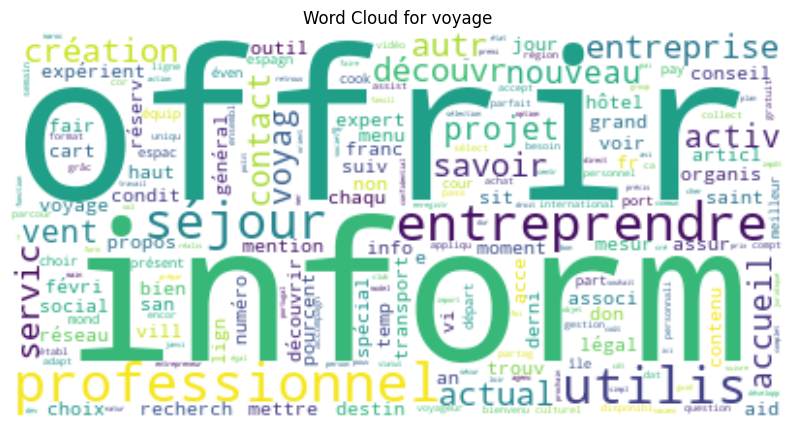

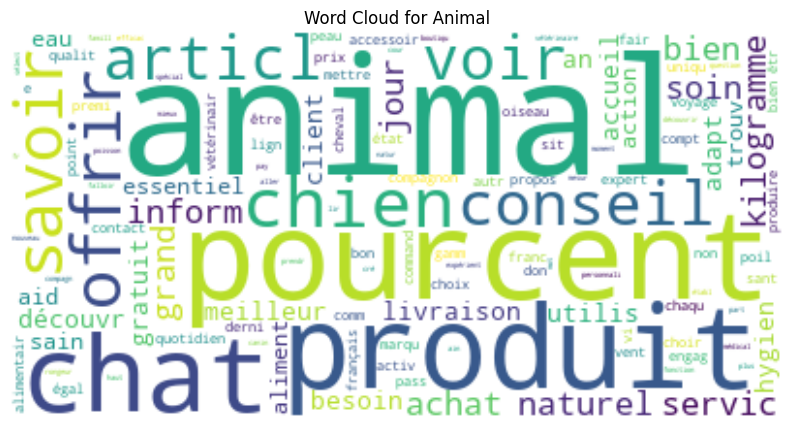

In [7]:
text = [word for word in df['content'].tolist() if word.lower() not in french_stopwords and word.lower() not in english_stopwords]
stemmed_text = [stemmer.stem(word) for word in text]
doc = nlp(" ".join(stemmed_text).strip())
tokens = [token.lemma_ for token in doc if not token.is_stop]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(tokens))
for label in df['label'].unique():
    class_text = " ".join(set(df[df['label'] == label]['content'].tolist()))
    wordcloud = WordCloud(stopwords=french_stopwords, background_color='white').generate(class_text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')
    plt.show()

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenized_data = tokenizer(df['content'].tolist(), padding=True, truncation=True, return_tensors='pt')

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
encoded_labels = torch.tensor(encoded_labels, dtype=torch.long)  # Convert to torch.LongTensor
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Train the Model
training_args = TrainingArguments(
    output_dir='results',
    num_train_epochs=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='logs',
)

class WebsiteDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

dataset = WebsiteDataset(tokenized_data, encoded_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.493300
1000,0.011400
1500,0.007100


TrainOutput(global_step=1500, training_loss=0.17059250211715699, metrics={'train_runtime': 3384.7627, 'train_samples_per_second': 3.471, 'train_steps_per_second': 0.443, 'total_flos': 3091665931776000.0, 'train_loss': 0.17059250211715699, 'epoch': 50.0})

In [11]:
model.save_pretrained('website_classifier_model')
tokenizer.save_pretrained('website_classifier_tokenizer')

('website_classifier_tokenizer\\tokenizer_config.json',
 'website_classifier_tokenizer\\special_tokens_map.json',
 'website_classifier_tokenizer\\vocab.txt',
 'website_classifier_tokenizer\\added_tokens.json',
 'website_classifier_tokenizer\\tokenizer.json')

In [47]:
test_url = "https://wiki.tn/"
content = fetch_content(test_url)
model = BertForSequenceClassification.from_pretrained('website_classifier_model')
tokenizer = BertTokenizerFast.from_pretrained('website_classifier_tokenizer')
tokenized_content = tokenizer(content, padding=True, truncation=True, return_tensors='pt')
model.eval()


with torch.no_grad():
    outputs = model(**tokenized_content)
    probabilities = F.softmax(outputs.logits, dim=-1)
    predicted_prob, predicted_class = torch.max(probabilities, dim=-1)

with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

predicted_label = label_encoder.inverse_transform(predicted_class.numpy())[0]
predicted_prob = predicted_prob.item()

print(f'The predicted label for the website is: {predicted_label} with probability: {predicted_prob:.4f}')

The predicted label for the website is: voyage with probability: 0.9994
